In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import APSIMGraphHelpers as AGH
import GraphHelpers as GH
import matplotlib.dates as mdates
import MathsUtilities as MUte
import sqlite3
import warnings

In [2]:
warnings.filterwarnings('ignore',category=pd.errors.PerformanceWarning)

In [3]:
Colors = {1:'#000000',
2:'#E69F00',
3:'#56B4E9',
4:'#009E73',
5:'#F0E442',
6:'#0072B2',
7:'#D55E00',
8:'#CC79A7',
9:'#1F77B4',
10:'#AEC7E8',
11:'#FF7F0E',
12:'#FFBB78',
13:'#2CA02C',
14:'#98DF8A',
15:'#D62728',
16:'#FF9896',
17:'#9467BD',
18:'#C5B0D5',
19:'#8C564B',
20:'#C49C94',
21:'#E377C2',
22:'#F7B6D2',
23:'#7F7F7F',
24:'#C7C7C7',
25:'#BCBD22',
26:'#DBDB8D',
27:'#17BECF',
28:'#9EDAE5'}

Markers = {1: 'o',
 2: '^',
 3: 's',
 4: '*',
 5: '>',
 6: 'v',
 7: '+',
 8: 'X',
 9: '<',
 10: 'p',
 11: '8',
 12: 'd',
 13:'P',
 14:'D',
 15:'o',
 16:'^'}

Lines = {1: '-',
 2: '--',
 3: '-,',
 4: ':',
 5: '-',
 6: '--',
 7: '-,',
 8: ':',
 9: '-',
 10: '--',
 11: '-,',
 12: ':',
 13: '-',
 14: '--',
 15: '-,',
 16: ':'}

In [217]:
np.ceil(120/17)

8.0

In [219]:
experiments.size

16

In [306]:
def plotxy(experiments,xvar,yvar,data,addLeg = True,ncols=np.nan):
    cpos=1
    mpos=1
    for e in experiments:
        plotData = data.loc[data.Experiment==e,:]
        plt.plot(plotData.loc[:,xvar],plotData.loc[:,yvar],Markers[mpos],color=Colors[cpos],label=e)
        cpos+=1
        mpos+=1
        if mpos>16:
            mpos=1
        if cpos>28:
            cpos=1
    if addLeg == True:
        if np.isnan(ncols):
             ncols = np.ceil(experiments.size/17)
        plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=ncols)
    plt.ylabel(yvar)
    plt.xlabel(xvar)

In [4]:
MasterfilePath = r'C:\GitHubRepos\ApsimX\Tests\Validation\Wheat\Wheat.db'

In [5]:
con = sqlite3.connect(MasterfilePath)
Simulations = pd.read_sql("Select * from _Simulations",con)
con.close()
Simulations.set_index('ID',inplace=True)
Simulations.sort_index(inplace=True)
Simulations.sort_index(inplace=True, axis=1)

In [6]:
SensibilityFolders = ['CO2AndTranspirationEfficiency',
'CO2AndTemperatureInteractions',
'ProteinAccumulation',
'LeafAppearance',
'TerminalWaterStress',
'DetailedDynamics']

In [7]:
con = sqlite3.connect(MasterfilePath)
HarvestPred = pd.read_sql("Select * from HarvestReport",con).dropna(axis=1,how='all')
con.close()
HarvestPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in HarvestPred.SimulationID]
HarvestPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
HarvestPred.sort_index(inplace=True)
HarvestPred.sort_index(inplace=True,axis=1)

# Filter outputs from sensibility tests
validationFilter = [x not in SensibilityFolders for x in HarvestPred.FolderName]
HarvestPred = HarvestPred.loc[validationFilter,:].copy()
HarvestPred.dropna(how='all',axis=1,inplace=True)
HarvestPred.loc[:,'Wheat.SowingData.Cultivar'] = [x.title() for x in HarvestPred.loc[:,'Wheat.SowingData.Cultivar']]
validationFilter = [x not in SensibilityFolders for x in HarvestPred.FolderName]
HarvestPred = HarvestPred.loc[validationFilter,:].copy()
HarvestPred.dropna(how='all',axis=1,inplace=True)
HarvestPred.sort_index(inplace=True)
HarvestPred.sort_index(inplace=True,axis=1)

# Replace Experiment with values that have had folder name pathed in where no experiment is present
HarvestPred.loc[[x is None for x in HarvestPred.Experiment],'Experiment'] = HarvestPred.loc[[x is None for x in HarvestPred.Experiment],'FolderName']

In [199]:
Experiments = list(HarvestPred.loc[:,'Experiment'].drop_duplicates().values)
Folders = list(HarvestPred.loc[:,'FolderName'].drop_duplicates().values)

In [8]:
con = sqlite3.connect(MasterfilePath)
DailyPred = pd.read_sql("Select * from DailyReport",con)
con.close()
DailyPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in DailyPred.SimulationID]
DailyPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
DailyPred.sort_index(inplace=True)
DailyPred.sort_index(inplace=True,axis=1)
validationFilter = [x not in SensibilityFolders for x in DailyPred.FolderName]
DailyPred = DailyPred.loc[validationFilter,:].copy()
DailyPred.dropna(how='all',axis=1,inplace=True)
# Replace Experiment with values that have had folder name path in where no experiment is present
DailyPred.loc[:,'Experiment'] = [HarvestPred.loc[x,'Experiment'] for x in DailyPred.index.get_level_values(0)]
DailyPred.loc[:,'Wheat.SowingData.Population'] = [HarvestPred.loc[x,'Wheat.SowingData.Population'].values[0] for x in DailyPred.index.get_level_values(0)]

## Join NDVI data into daily obs
con = sqlite3.connect(MasterfilePath)
NDVIPred = pd.read_sql("Select * from NDVIDailyReport",con)
con.close()
NDVIPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in NDVIPred.SimulationID]
NDVIPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
NDVIPred.sort_index(inplace=True)
NDVIPred.sort_index(inplace=True,axis=1)

validationFilter = [x not in SensibilityFolders for x in NDVIPred.FolderName]
NDVIPred = NDVIPred.loc[validationFilter,:].copy()
NDVIPred.dropna(how='all',axis=1,inplace=True)
##Join NDVI predictions in with others 
for i in NDVIPred.index:
    DailyPred.loc[i,'NDVIModel.Script.NDVI'] = NDVIPred.loc[i,'NDVIModel.Script.NDVI']

In [9]:
## Join NDVI data into daily obs
con = sqlite3.connect(MasterfilePath)
NDVIPred = pd.read_sql("Select * from NDVIDailyReport",con)
con.close()
NDVIPred.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in NDVIPred.SimulationID]
NDVIPred.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
NDVIPred.sort_index(inplace=True)
NDVIPred.sort_index(inplace=True,axis=1)

validationFilter = [x not in SensibilityFolders for x in NDVIPred.FolderName]
NDVIPred = NDVIPred.loc[validationFilter,:].copy()
NDVIPred.dropna(how='all',axis=1,inplace=True)
##Join NDVI predictions in with others 
for i in NDVIPred.index:
    DailyPred.loc[i,'NDVIModel.Script.NDVI'] = NDVIPred.loc[i,'NDVIModel.Script.NDVI']
NDVIPred.sort_index(inplace=True)
NDVIPred.sort_index(inplace=True,axis=1)

In [270]:
simulations = DailyPred.index.get_level_values(0).drop_duplicates()
RunningMeans = pd.DataFrame(index = DailyPred.index)
MetVars = ['IWeather.MaxT',
'IWeather.MinT',
'IWeather.Radn',
'Wheat.Phenology.PTQ']

def running_mean(inp,span):
    return [sum(x)/len(x) for x in (inp[max(0,i-span):i] for i in range(1, len(inp)+1))]

for mv in MetVars:
    for s in simulations:
        inp = list(DailyPred.loc[s,mv].values)
        RunningMeans.loc[s,mv] = running_mean(inp,30)
        

In [110]:
SowIndices = ['IWeather.Latitude',
    'IWeather.Longitude',
    'LocationInfo.Script.Country',
    'LocationInfo.Script.Region',
    'LocationInfo.Script.State',
    'Wheat.SowingData.Cultivar',
    'Experiment',
    'FolderName']

def getValue(ind,var,HarvestPred):
    try:
        return HarvestPred.loc[ind,var].values[0]
    except:
        return ""

con = sqlite3.connect(MasterfilePath)
Observed = pd.read_sql("Select * from Observed",con).dropna(axis=1,how='all')
con.close()
Observed.loc[:,'SimulationName'] = [Simulations.loc[x,'Name'] for x in Observed.SimulationID]
Observed.set_index(['SimulationName','Clock.Today'],drop=False,inplace=True)
Observed.sort_index(inplace=True)
Observed.sort_index(inplace=True,axis=1)
for s in SowIndices:
    Observed.loc[:,s] = [getValue(x,s,HarvestPred) for x in Observed.index.get_level_values(0)]

def subtract(a,b):
    if np.isnan(b):
        b = 0
    return a - b

Observed.loc[:,'Wheat.AboveGroundLive.Wt'] = [subtract(Observed.iloc[x,:]['Wheat.AboveGround.Wt'], Observed.iloc[x,:]['Wheat.Leaf.Dead.Wt']) for x in range(Observed.index.size)]

In [277]:
MasterIndexVars = ['Clock.Today',
'IWeather.MaxT',
'IWeather.MinT',
'IWeather.Radn',
'Wheat.DaysAfterSowing',
'Wheat.Phenology.AccumulatedTT',
'Wheat.Phenology.PTQ',
'Wheat.Phenology.CurrentPhaseName',
'Wheat.Phenology.CurrentStageName',
'Wheat.Phenology.Stage']

for iv in MasterIndexVars:
    Observed.loc[:,iv] = DailyPred.reindex(Observed.index).loc[:,iv]    

In [284]:
for iv in MetVars:
    Observed.loc[:,'RunningMean_'+iv] = RunningMeans.reindex(Observed.index).loc[:,iv]  

In [112]:
MasterIndexVarsHarv = ['SimulationID','SimulationName']

for iv in MasterIndexVarsHarv:
    Observed.loc[:,iv] = HarvestPred.reindex(Observed.index).loc[:,iv]  


def setvar(x):
    if np.isnan(Observed.loc[x,'Wheat.Population'].values[0]):
        try:
            if ~np.isnan(HarvestPred.loc[x,'Wheat.SowingData.Population'].values[0]):
                Observed.loc[x,'Wheat.Population'] = HarvestPred.loc[x,'Wheat.SowingData.Population'].values[0]
        except:
            try:
                if ~np.isnan(HarvestPred.loc[x[0],'Wheat.SowingData.Population'].values[0]):
                    Observed.loc[x,'Wheat.Population'] = HarvestPred.loc[x[0],'Wheat.SowingData.Population'].values[0]
            except:
                do = 'Nothing'

for x in Observed.index:
        setvar(x)

Observed.sort_index(inplace=True)
Observed.sort_index(inplace=True,axis=1)

In [142]:
#Make data frame with factor information for each simulation
FactorList = [ 'Experiment',
 'Canopy',
 'Cm',
 'Cultivar',
 'Cv',
 'Date',
 'Durat',
 'Fungicide',
 'Grazed',
 'Irr',
 'Irrig',
 'Mgmt',
 'N',
 'NRate',
 'Nit',
 'Nutrition',
 'P',
 'PGR',
 'Popn',
 'Removal',
 'RowSpace',
 'SD',
 'Seeds',
 'Soil',
 'Sow',
 'SowN',
 'Stubble',
 'TOS',
 'TopN',
 'Treat',
 'Treatment',
 'V',
 'Water']

Factors = HarvestPred.loc[:,FactorList].copy()
Factors.index = Factors.index.droplevel(1)
Factors.set_index('Experiment',append=True,inplace=True)
Factors=Factors.reorder_levels(['Experiment','SimulationName'])
Factors.sort_index(inplace=True)
CondensedFactors = pd.DataFrame(index = Factors.index,columns = ['fName1','fValue1'])
for s in Factors.index:
    fs = Factors.loc[s,:].dropna().to_dict()
    fCount = 1
    for key, value in fs.items():
        CondensedFactors.loc[s,'fName'+str(fCount)] = key
        CondensedFactors.loc[s,'fValue'+str(fCount)] = value
        fCount +=1
valueLabs = ['fValue1','fValue2','fValue3','fValue4']
indexLabs = ['fIndex1','fIndex2','fIndex3','fIndex4']
CondensedFactors.loc[:,indexLabs]=1

# put simulation names in as first factor level for sims that are not in a experiment
for e in Experiments:
    fValues1 = CondensedFactors.loc[e,'fValue1']
    if True in pd.isna(fValues1.values):
        CondensedFactors.loc[e,'fValue1'] = CondensedFactors.loc[e,:].index.values
        
#assign numeric index to each factor level
for e in Experiments:
    for v in valueLabs:
        fLevels = CondensedFactors.loc[e,v].drop_duplicates().values
        if False in pd.isna(fLevels):
            levelDic = dict(zip(fLevels,list(range(1,len(fLevels )+1))))
            CondensedFactors.loc[e,v.replace('Value','Index')] = [levelDic[x] for x in CondensedFactors.loc[e,v]]

In [114]:
a = 'Wheat.Leaf.StemPopulation'
b = 'Wheat.Leaf.StemNumberPerPlant'
c = 'Wheat.Population'

def FillDataGap(set):
    a,b,c = set.values[0],set.values[1],set.values[2]
    if sum(np.isnan([a,b,c])) == 0:
        return [a,b,c]
    if sum(np.isnan([a,b,c])) > 1:
        return [a,b,c]
    if sum(np.isnan([a,b,c])) == 1:
        if np.isnan(a):
            a = b * c
        if np.isnan(b):
            b = a/c
        if np.isnan(c):
            c = a/b
        return [a,b,c]
    
Observed.sort_index(axis=1,inplace=True)
Observed.sort_index(axis=1,inplace=True)
Observed.loc[:,[a,b,c]] = [FillDataGap(Observed.iloc[x,:][[a,b,c]]) for x in range(Observed.index.size)]

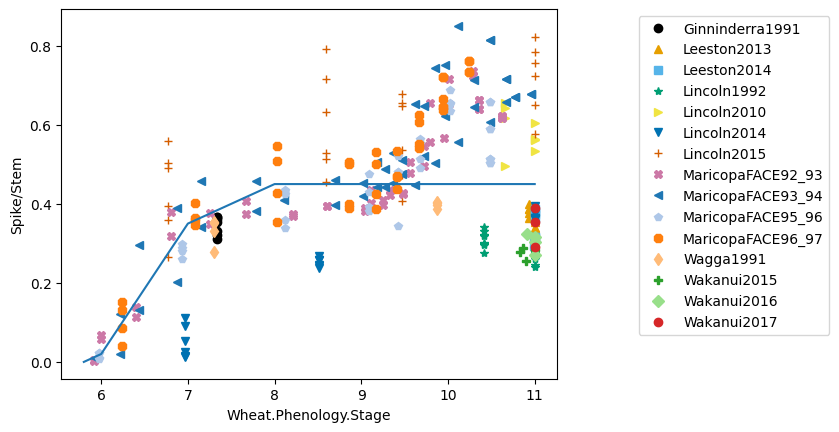

In [229]:
Observed.loc[:,'Spike/Stem'] = Observed.loc[:,'Wheat.Spike.Wt']/Observed.loc[:,'Wheat.Stem.Wt']
xvar,yvar = 'Wheat.Phenology.Stage','Spike/Stem'
experiments = Observed.dropna(subset=[xvar,yvar]).Experiment.drop_duplicates()
plotxy(experiments,xvar,yvar,Observed)
plt.plot([5.8,6.0,7.0,8.0,11.0],
         [0.0,.02,.35,.45,.45],'-')

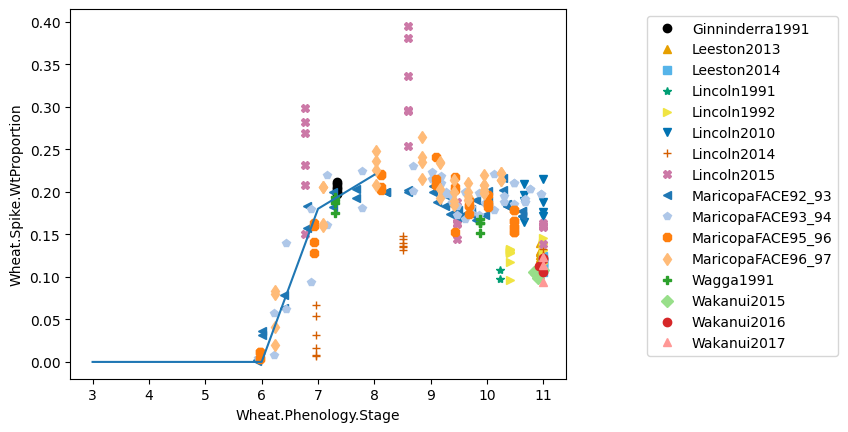

In [307]:
Observed.loc[:,'Wheat.Spike.WtProportion'] = Observed.loc[:,'Wheat.Spike.Wt']/Observed.loc[:,'Wheat.AboveGroundLive.Wt']
xvar,yvar = 'Wheat.Phenology.Stage','Wheat.Spike.WtProportion'
experiments = Observed.dropna(subset=[xvar,yvar]).Experiment.drop_duplicates()
plotxy(experiments,xvar,yvar,Observed)
plt.plot([3.0,6,7.0,8.0,],
         [0,0,.18,.22],'-')

(0.0, 0.9)

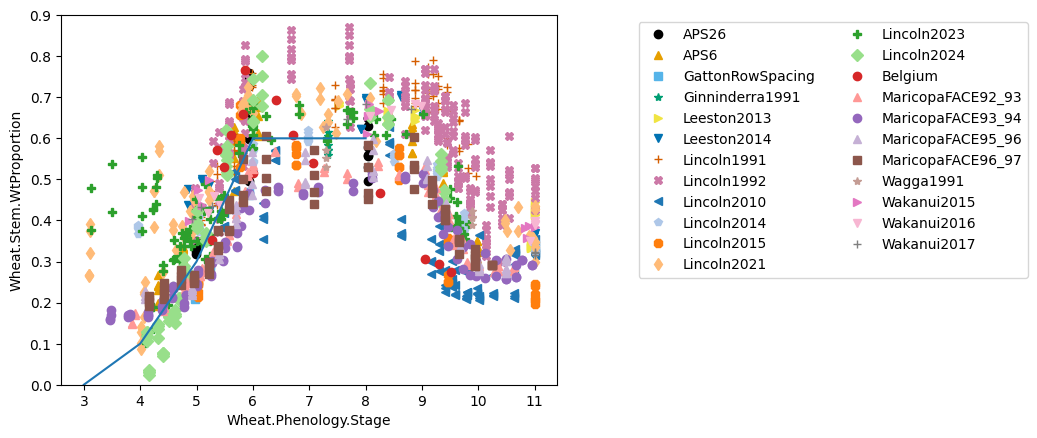

In [232]:
Observed.loc[:,'Wheat.Stem.WtProportion'] = Observed.loc[:,'Wheat.Stem.Wt']/Observed.loc[:,'Wheat.AboveGroundLive.Wt']
xvar,yvar = 'Wheat.Phenology.Stage','Wheat.Stem.WtProportion'
experiments = Observed.dropna(subset=[xvar,yvar]).Experiment.drop_duplicates()
plotxy(experiments,xvar,yvar,Observed)
plt.plot([3.0,4.0,5.0,6.0,8.0],
         [0.0,.1,.3,.6,.6],'-')
plt.ylim(0,.9)

(0.0, 1.0)

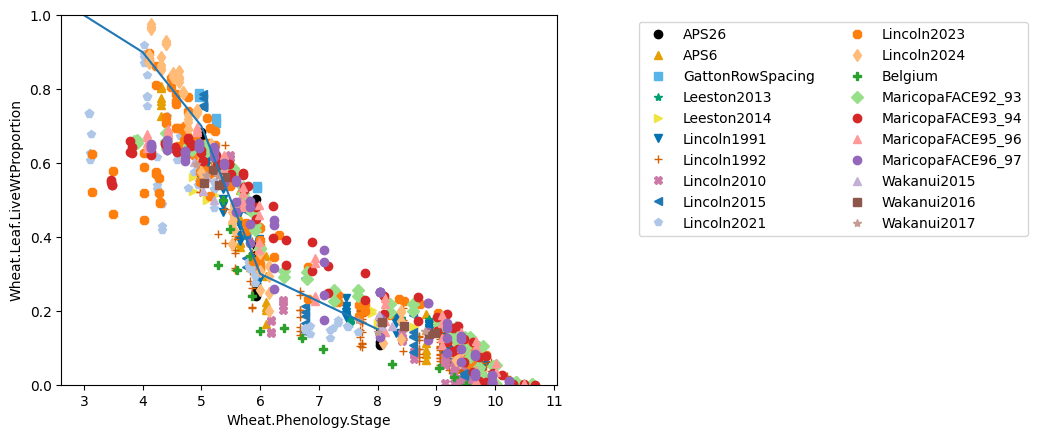

In [234]:
Observed.loc[:,'Wheat.Leaf.LiveWtProportion'] = Observed.loc[:,'Wheat.Leaf.Live.Wt']/Observed.loc[:,'Wheat.AboveGroundLive.Wt']
xvar,yvar = 'Wheat.Phenology.Stage','Wheat.Leaf.LiveWtProportion'
experiments = Observed.dropna(subset=[xvar,yvar]).Experiment.drop_duplicates()
plotxy(experiments,xvar,yvar,Observed)
plt.plot([3.0,4.0,5.0,6.0,8.0],
         [1,.9,.7,.3,.15],'-')
plt.ylim(0,1)

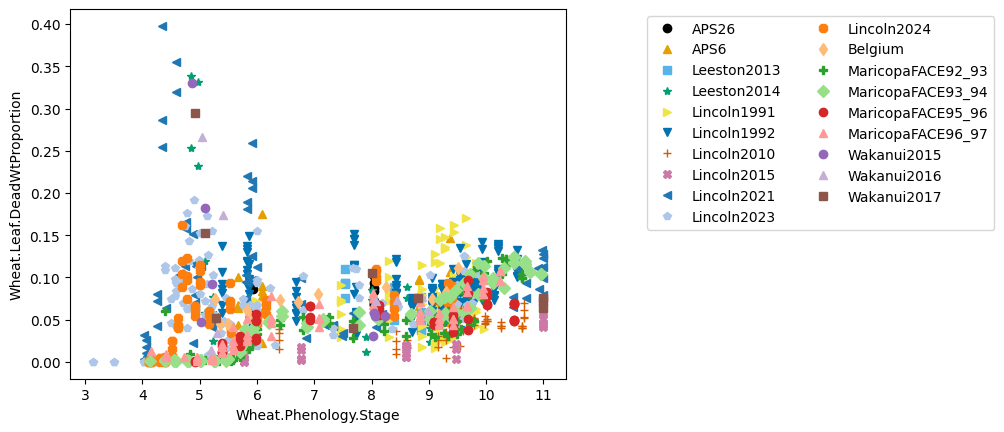

In [242]:
Observed.loc[:,'Wheat.Leaf.DeadWtProportion'] = Observed.loc[:,'Wheat.Leaf.Dead.Wt']/Observed.loc[:,'Wheat.AboveGround.Wt']
xvar,yvar = 'Wheat.Phenology.Stage','Wheat.Leaf.DeadWtProportion'
experiments = Observed.dropna(subset=[xvar,yvar]).Experiment.drop_duplicates()
plotxy(experiments,xvar,yvar,Observed)

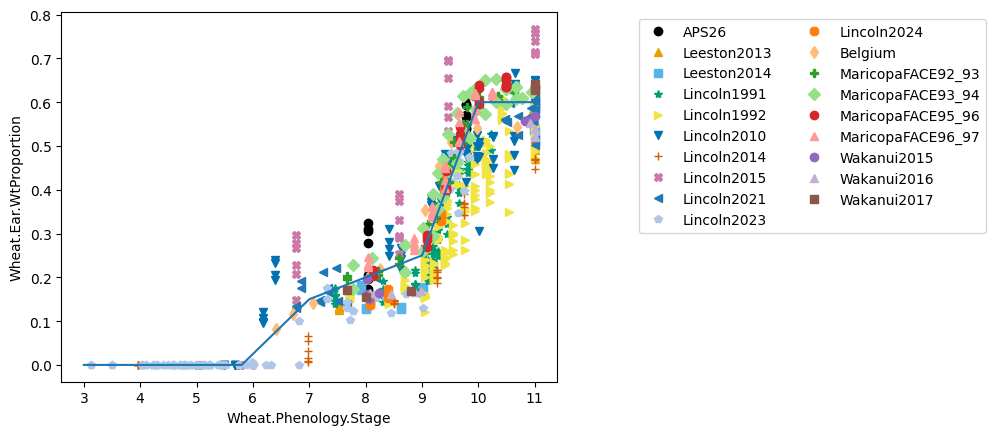

In [241]:
Observed.loc[:,'Wheat.Ear.WtProportion'] = Observed.loc[:,'Wheat.Ear.Wt']/Observed.loc[:,'Wheat.AboveGround.Wt']
xvar,yvar = 'Wheat.Phenology.Stage','Wheat.Ear.WtProportion'
experiments = Observed.dropna(subset=[xvar,yvar]).Experiment.drop_duplicates()
plotxy(experiments,xvar,yvar,Observed)
plt.plot([3.0,5.8,7.0,8.0,9.0,10,11],
         [0,0,.15,.2,.25,0.6,0.6],'-')


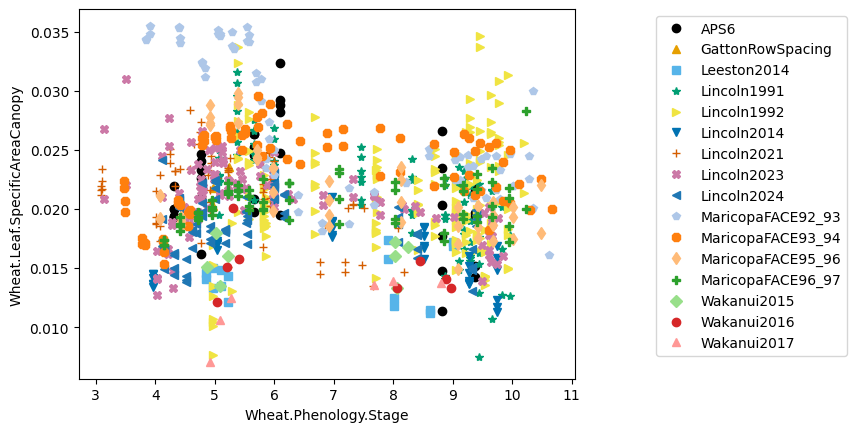

In [243]:
xvar,yvar = 'Wheat.Phenology.Stage','Wheat.Leaf.SpecificAreaCanopy'
experiments = Observed.dropna(subset=[xvar,yvar]).Experiment.drop_duplicates()
plotxy(experiments,xvar,yvar,Observed)

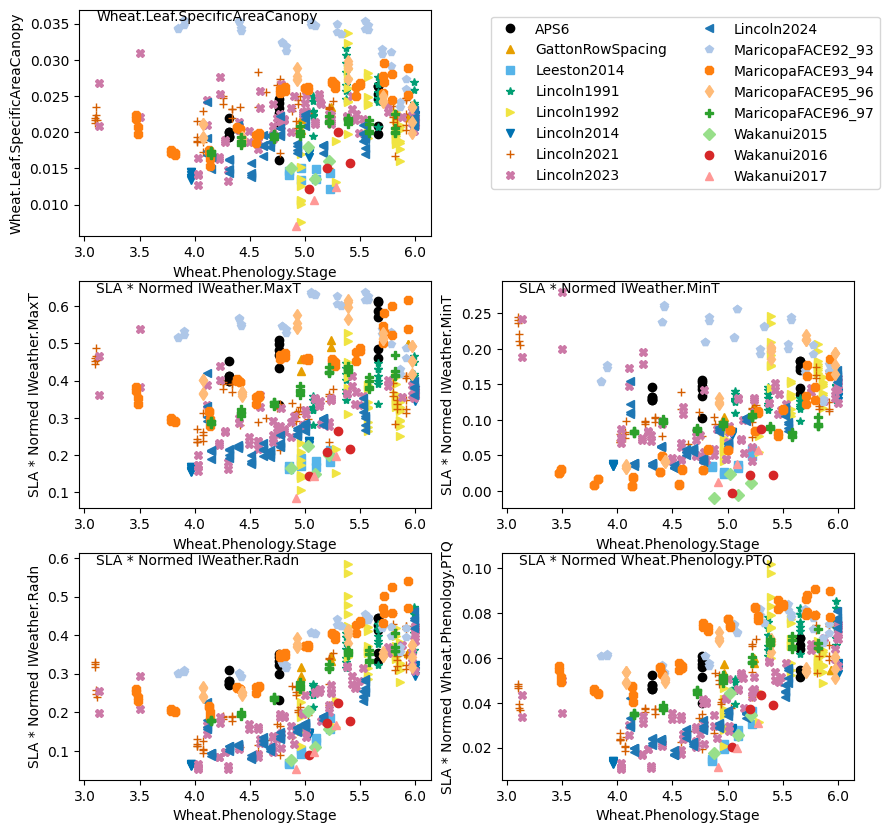

In [319]:
testData = Observed.loc[Observed.loc[:,'Wheat.Phenology.Stage']<=6,:]
graph = plt.figure(figsize=(10,10))
ax = graph.add_subplot(3,2,1)
experiments = Observed.dropna(subset=[xvar,yvar]).Experiment.drop_duplicates()
xvar,yvar = 'Wheat.Phenology.Stage','Wheat.Leaf.SpecificAreaCanopy'
plotxy(experiments,xvar,yvar,testData,ncols=2)
plt.text(0.05,0.95,'Wheat.Leaf.SpecificAreaCanopy',transform=ax.transAxes)
pos=3
for mv in MetVars:
    Observed.loc[:,'SLA * Normed '+mv] = Observed.loc[:,'Wheat.Leaf.SpecificAreaCanopy']*Observed.loc[:,'RunningMean_'+mv]
    ax = graph.add_subplot(3,2,pos)
    xvar,yvar = 'Wheat.Phenology.Stage','SLA * Normed '+mv
    experiments = Observed.dropna(subset=[xvar,yvar]).Experiment.drop_duplicates()
    plotxy(experiments,xvar,yvar,testData,addLeg=False)
    plt.text(0.05,0.95,'SLA * Normed '+mv,transform=ax.transAxes)
    pos+=1

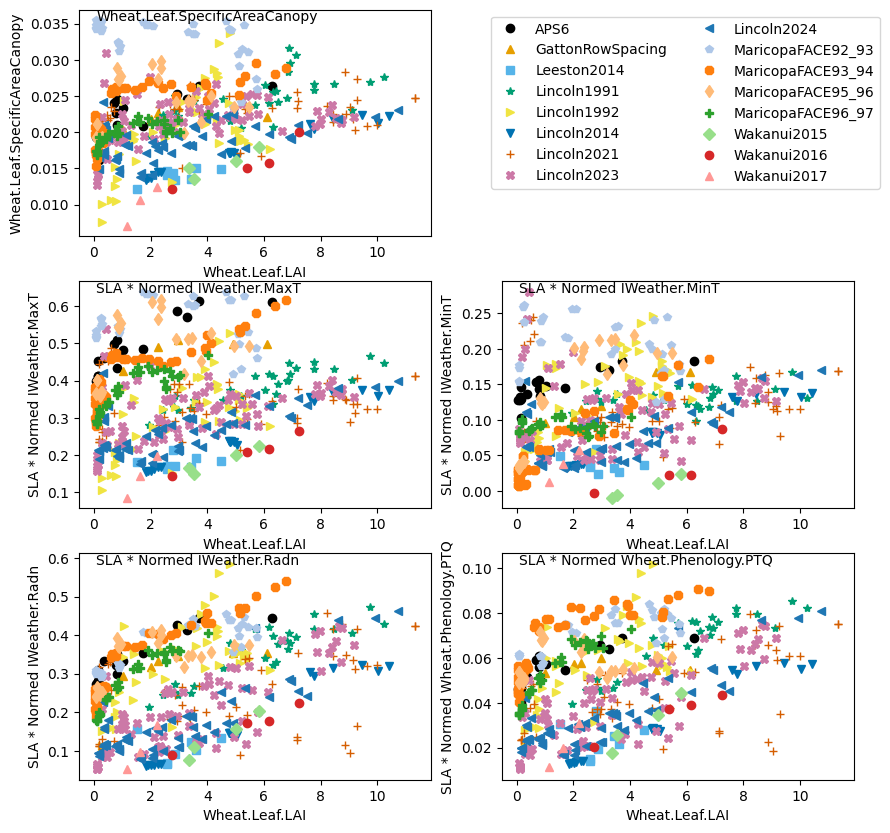

In [314]:
testData = Observed.loc[Observed.loc[:,'Wheat.Phenology.Stage']<=6,:]
graph = plt.figure(figsize=(10,10))


ax = graph.add_subplot(3,2,1)
experiments = Observed.dropna(subset=[xvar,yvar]).Experiment.drop_duplicates()
xvar,yvar = 'Wheat.Leaf.LAI','Wheat.Leaf.SpecificAreaCanopy'
plotxy(experiments,xvar,yvar,testData,ncols=2)
plt.text(0.05,0.95,'Wheat.Leaf.SpecificAreaCanopy',transform=ax.transAxes)
pos=3
for mv in MetVars:
    Observed.loc[:,'SLA * Normed '+mv] = Observed.loc[:,'Wheat.Leaf.SpecificAreaCanopy']*Observed.loc[:,'RunningMean_'+mv]
    ax = graph.add_subplot(3,2,pos)
    xvar,yvar = 'Wheat.Leaf.LAI','SLA * Normed '+mv
    experiments = Observed.dropna(subset=[xvar,yvar]).Experiment.drop_duplicates()
    plotxy(experiments,xvar,yvar,testData,addLeg=False)
    plt.text(0.05,0.95,'SLA * Normed '+mv,transform=ax.transAxes)
    pos+=1

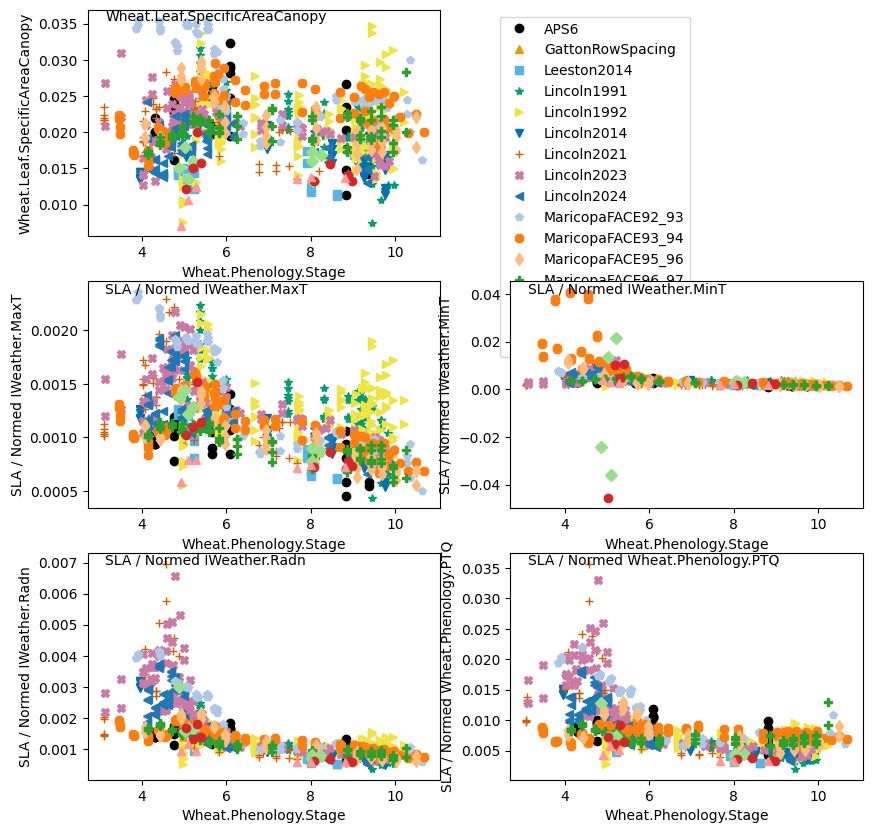

In [305]:
graph = plt.figure(figsize=(10,10))

ax = graph.add_subplot(3,2,1)
experiments = Observed.dropna(subset=[xvar,yvar]).Experiment.drop_duplicates()
xvar,yvar = 'Wheat.Phenology.Stage','Wheat.Leaf.SpecificAreaCanopy'
plotxy(experiments,xvar,yvar,Observed)
plt.text(0.05,0.95,'Wheat.Leaf.SpecificAreaCanopy',transform=ax.transAxes)
pos=3
for mv in MetVars:
    Observed.loc[:,'SLA / Normed '+mv] = Observed.loc[:,'Wheat.Leaf.SpecificAreaCanopy']/Observed.loc[:,'RunningMean_'+mv]
    ax = graph.add_subplot(3,2,pos)
    xvar,yvar = 'Wheat.Phenology.Stage','SLA / Normed '+mv
    experiments = Observed.dropna(subset=[xvar,yvar]).Experiment.drop_duplicates()
    plotxy(experiments,xvar,yvar,Observed,addLeg=False)
    plt.text(0.05,0.95,'SLA / Normed '+mv,transform=ax.transAxes)
    pos+=1

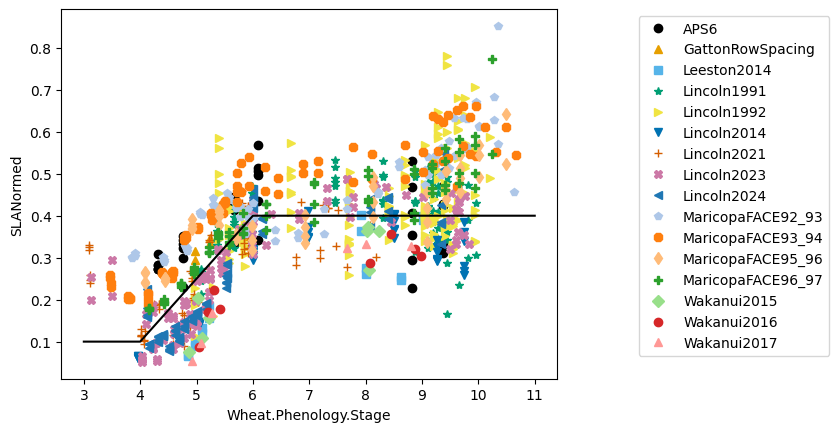

In [311]:
Observed.loc[:,'SLANormed'] = Observed.loc[:,'Wheat.Leaf.SpecificAreaCanopy']*Observed.loc[:,'RunningMean_IWeather.Radn']
xvar,yvar = 'Wheat.Phenology.Stage','SLANormed'
experiments = Observed.dropna(subset=[xvar,yvar]).Experiment.drop_duplicates()
plotxy(experiments,xvar,yvar,Observed)
plt.plot([3,4,6,11],[.1,.1,.4,.4],'-',color='k')

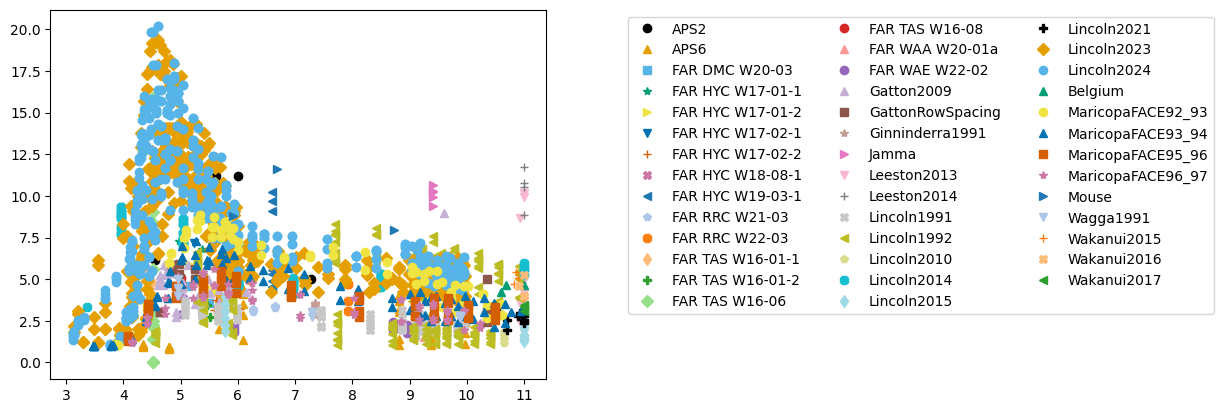

In [108]:
vars = ['Wheat.Leaf.StemNumberPerPlant','Wheat.Phenology.Stage']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemNumberPerPlant'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

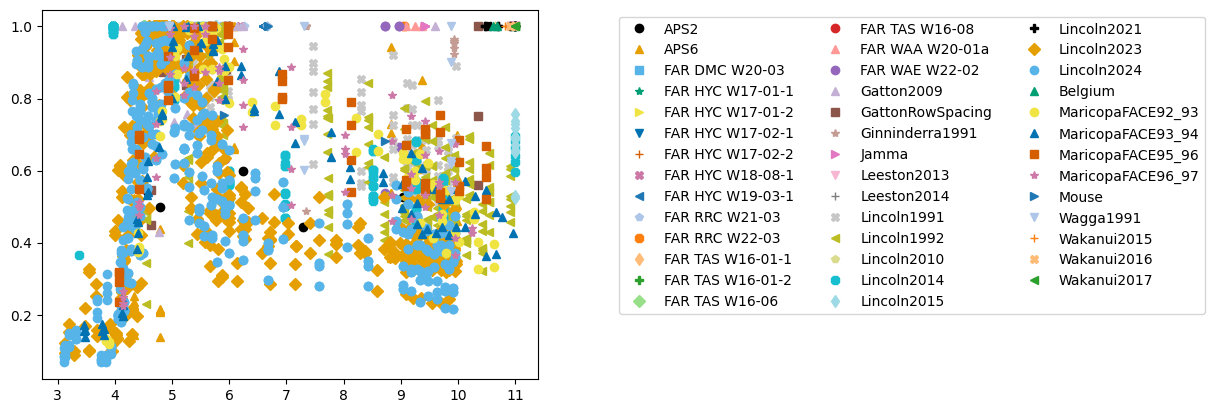

In [26]:
vars = ['Wheat.Leaf.StemNumberPerPlant','Wheat.Phenology.Stage']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    sims = exData.index.get_level_values(0).drop_duplicates()
    spos = 0
    for s in sims:
        maxSN = exData.loc[s,'Wheat.Leaf.StemNumberPerPlant'].max()
        if spos == 0:
            plt.plot(exData.loc[s,'Wheat.Phenology.Stage'],exData.loc[s,'Wheat.Leaf.StemNumberPerPlant']/maxSN,Markers[mpos],color=Colors[cpos],label=e)
        else:
            plt.plot(exData.loc[s,'Wheat.Phenology.Stage'],exData.loc[s,'Wheat.Leaf.StemNumberPerPlant']/maxSN,Markers[mpos],color=Colors[cpos])
        spos+=1
    cpos+=1
    mpos+=1
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

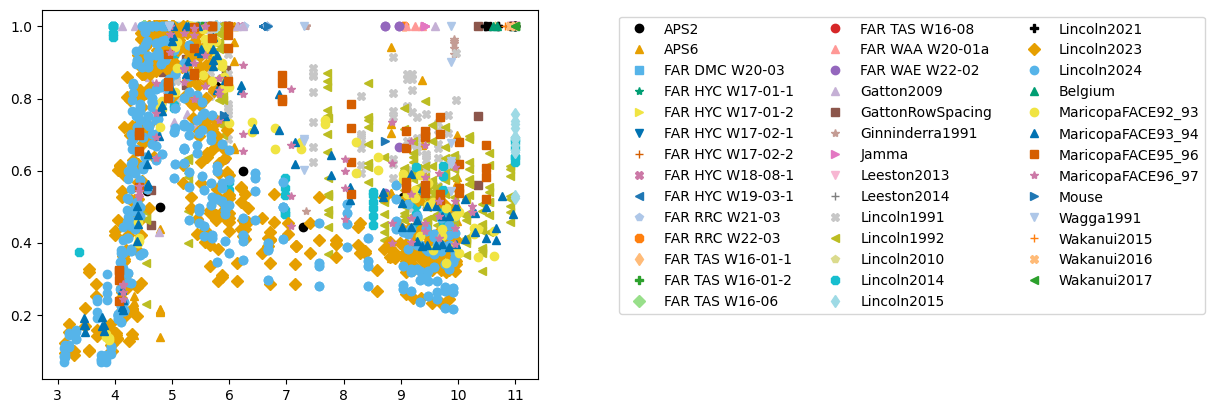

In [34]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    sims = exData.index.get_level_values(0).drop_duplicates()
    spos = 0
    for s in sims:
        maxSN = exData.loc[s,'Wheat.Leaf.StemPopulation'].max()
        if spos == 0:
            plt.plot(exData.loc[s,'Wheat.Phenology.Stage'],exData.loc[s,'Wheat.Leaf.StemPopulation']/maxSN,Markers[mpos],color=Colors[cpos],label=e)
        else:
            plt.plot(exData.loc[s,'Wheat.Phenology.Stage'],exData.loc[s,'Wheat.Leaf.StemPopulation']/maxSN,Markers[mpos],color=Colors[cpos])
        spos+=1
    cpos+=1
    mpos+=1
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

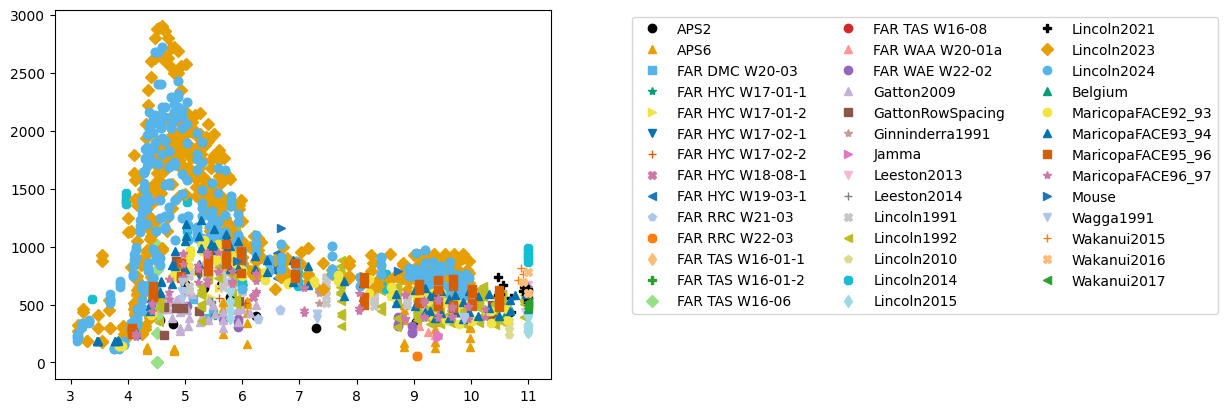

In [27]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage']+['Experiment']
data = Observed.loc[:,vars].dropna()
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
for e in Experiments:
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemPopulation'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

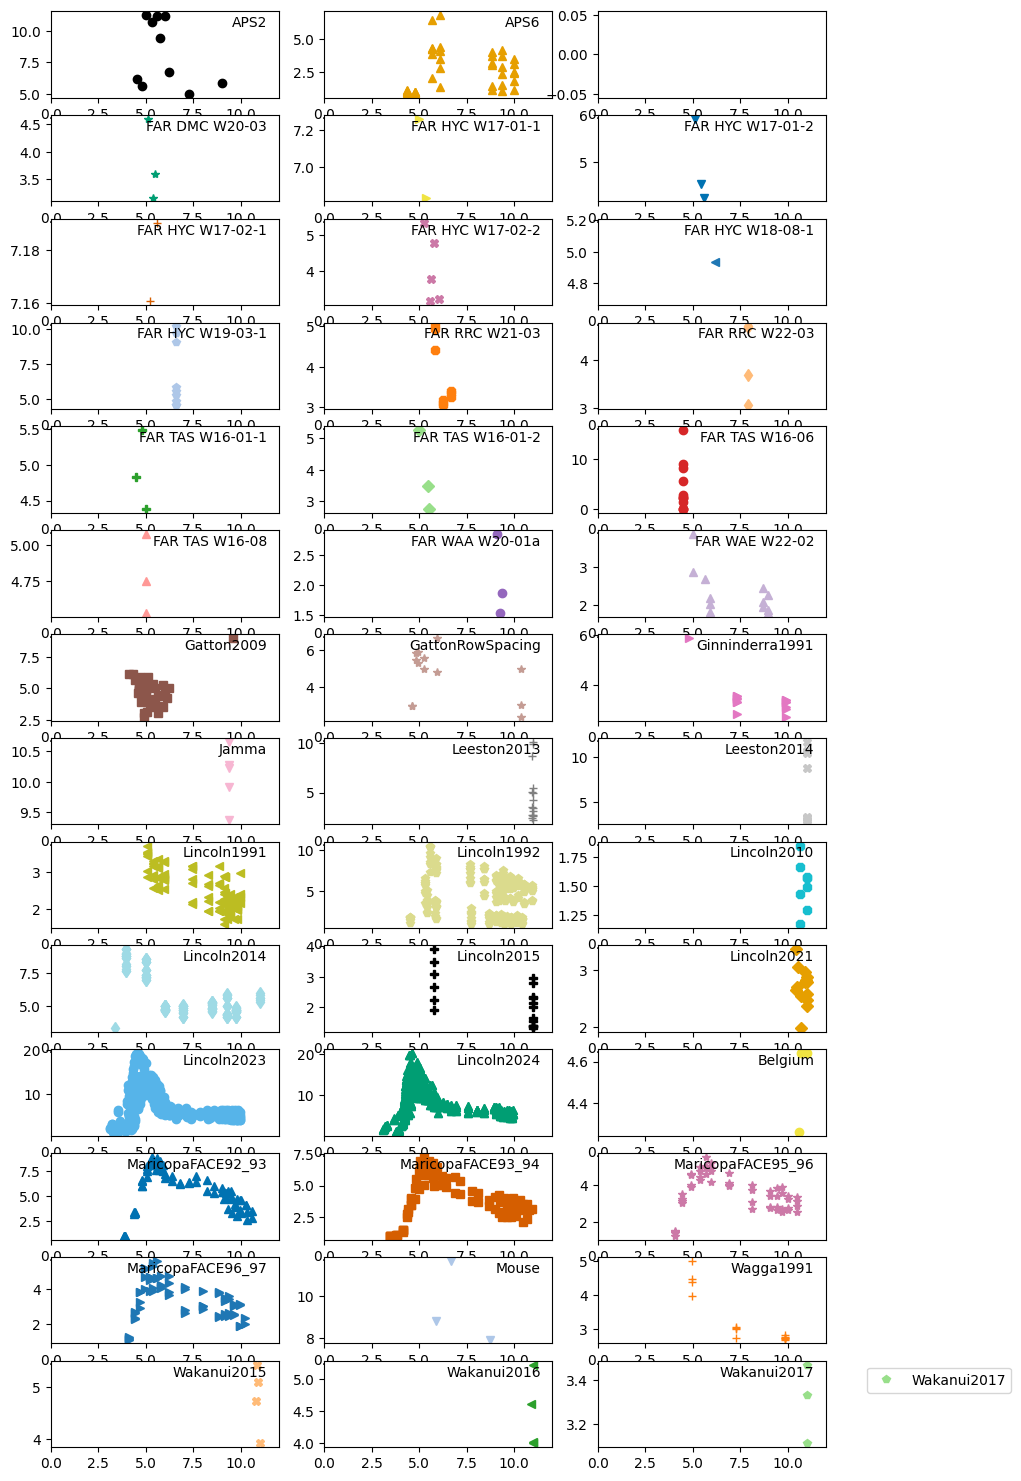

In [124]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.Population','Wheat.Phenology.AccumulatedTT','Wheat.Leaf.StemNumberPerPlant']+['Experiment']
data = Observed.loc[:,vars].dropna(subset= ['Wheat.Leaf.StemPopulation','Wheat.Leaf.StemNumberPerPlant'],how='all')
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
pos=1
graph = plt.figure(figsize=(10,20))
for e in Experiments:
    ax = graph.add_subplot(15,3,pos)
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemNumberPerPlant'],Markers[mpos],color=Colors[cpos],label=e)
    plt.text(0.95,0.95,e,transform = ax.transAxes,horizontalalignment='right', verticalalignment='top')
    plt.xlim(0,12)
    cpos+=1
    mpos+=1
    pos+=1               
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

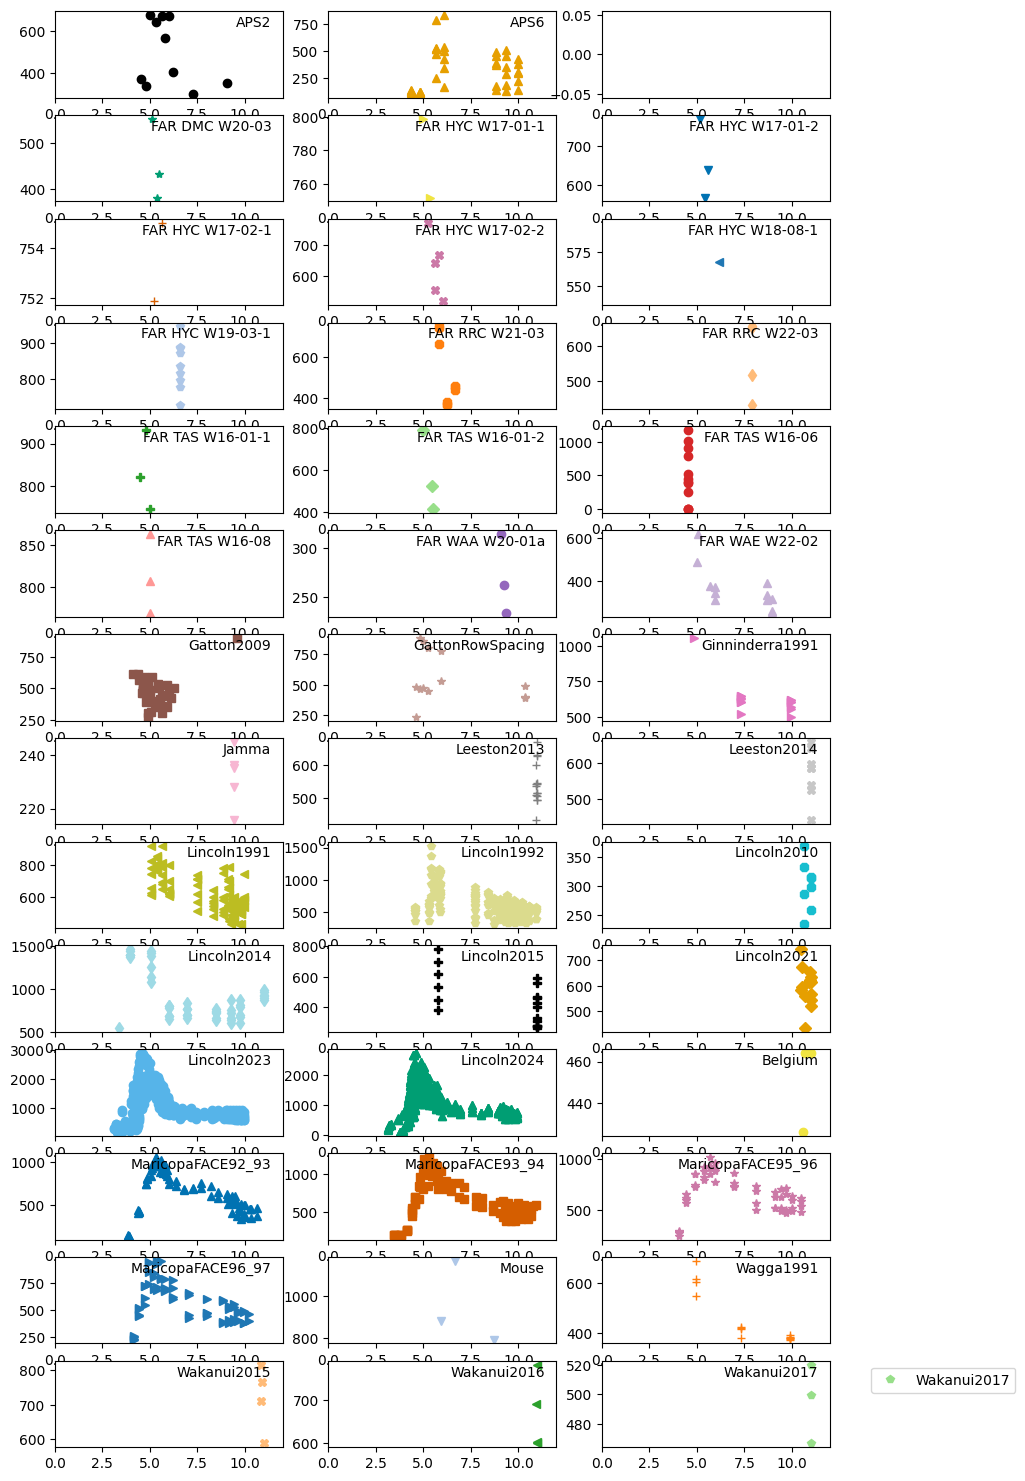

In [123]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.Population','Wheat.Phenology.AccumulatedTT','Wheat.Leaf.StemNumberPerPlant']+['Experiment']
data = Observed.loc[:,vars].dropna(subset= ['Wheat.Leaf.StemPopulation','Wheat.Leaf.StemNumberPerPlant'],how='all')
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
pos=1
graph = plt.figure(figsize=(10,20))
for e in Experiments:
    ax = graph.add_subplot(15,3,pos)
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Leaf.StemPopulation'],Markers[mpos],color=Colors[cpos],label=e)
    plt.text(0.95,0.95,e,transform = ax.transAxes,horizontalalignment='right', verticalalignment='top')
    plt.xlim(0,12)
    cpos+=1
    mpos+=1
    pos+=1               
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

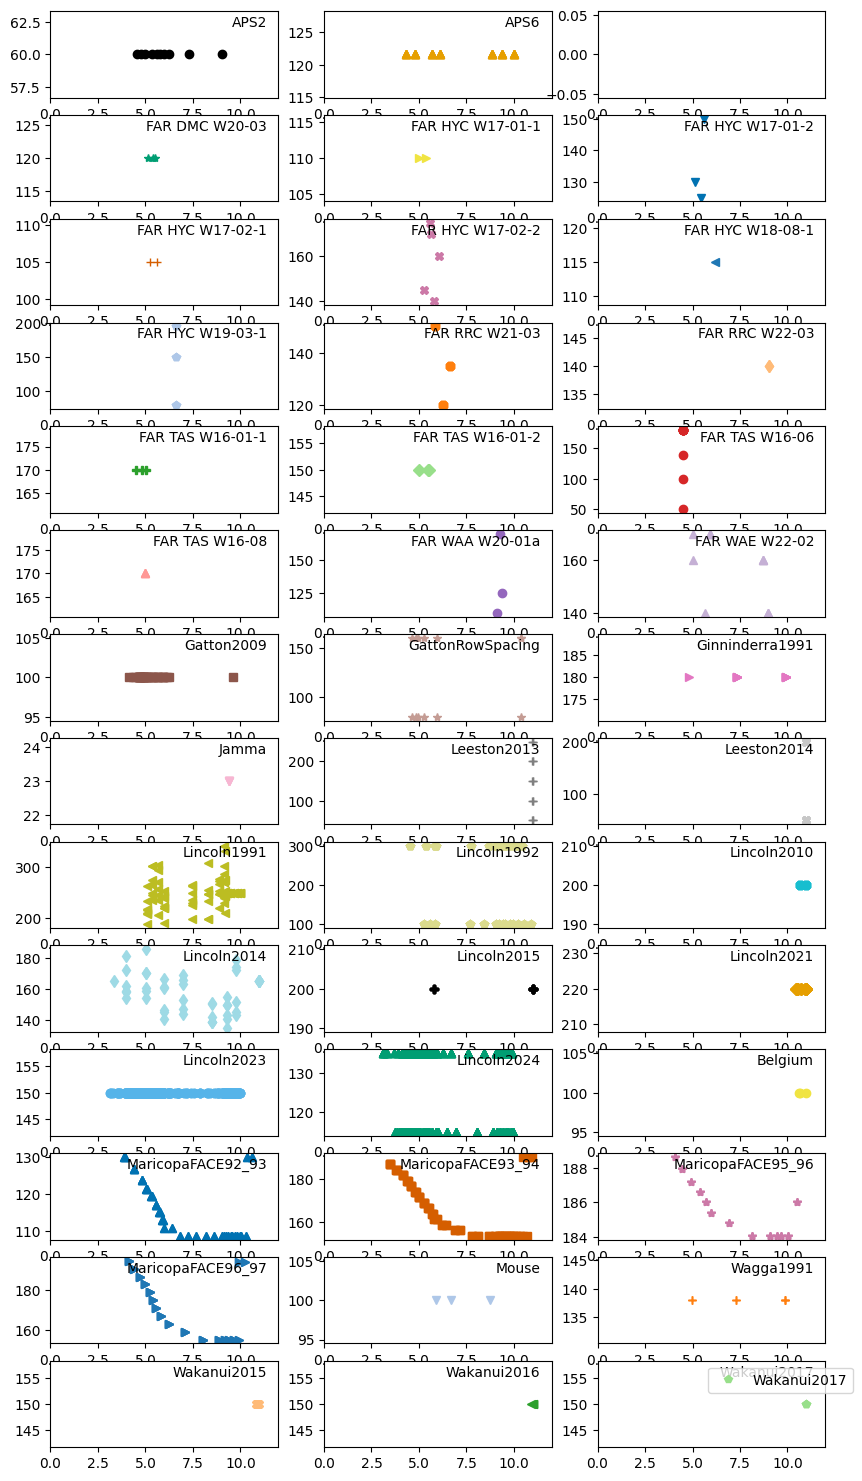

In [30]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.Population','Wheat.Phenology.AccumulatedTT','Wheat.Leaf.StemNumberPerPlant']+['Experiment']
data = Observed.loc[:,vars].dropna(subset= ['Wheat.Leaf.StemPopulation','Wheat.Leaf.StemNumberPerPlant'],how='all')
Experiments = data.Experiment.drop_duplicates()
cpos=1
mpos=1
pos=1
graph = plt.figure(figsize=(10,20))
for e in Experiments:
    ax = graph.add_subplot(15,3,pos)
    exData = data.loc[data.Experiment == e,:]
    plt.plot(exData.loc[:,'Wheat.Phenology.Stage'],exData.loc[:,'Wheat.Population'],Markers[mpos],color=Colors[cpos],label=e)
    plt.text(0.95,0.95,e,transform = ax.transAxes,horizontalalignment='right', verticalalignment='top')
    plt.xlim(0,12)
    cpos+=1
    mpos+=1
    pos+=1               
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)

In [182]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.Population','Wheat.Phenology.AccumulatedTT','Wheat.Leaf.StemNumberPerPlant']
data = Observed.loc[:,vars].dropna(subset= ['Wheat.Leaf.StemPopulation','Wheat.Leaf.StemNumberPerPlant'],how='all')
MeanStemData = data.loc[data.loc[:,'Wheat.Phenology.Stage']>7.5,:].groupby('SimulationName').mean()
MeanStemData.loc[:,'Experiment'] = [getValue(x,'Experiment',HarvestPred) for x in MeanStemData.index]

vars = ['Wheat.Stem.Wt','Wheat.Phenology.Stage']
data = Observed.loc[:,vars].dropna()
MeanStemWtData = data.loc[(data.loc[:,'Wheat.Phenology.Stage']>6.4)&(data.loc[:,'Wheat.Phenology.Stage']<9),:].groupby('SimulationName').mean()
MeanStemWtData.loc[:,'Experiment'] = [getValue(x,'Experiment',HarvestPred) for x in MeanStemWtData.index]
MeanStemData.loc[:,'Wheat.Stem.Wt'] = MeanStemWtData.reindex(MeanStemData.index).loc[:,'Wheat.Stem.Wt']
MeanStemData.loc[:,'MeanStemWt'] = MeanStemData.loc[:,'Wheat.Stem.Wt']/MeanStemData.loc[:,'Wheat.Leaf.StemPopulation']  

Text(0.5, 0, 'Wheat.population (plants/m2)')

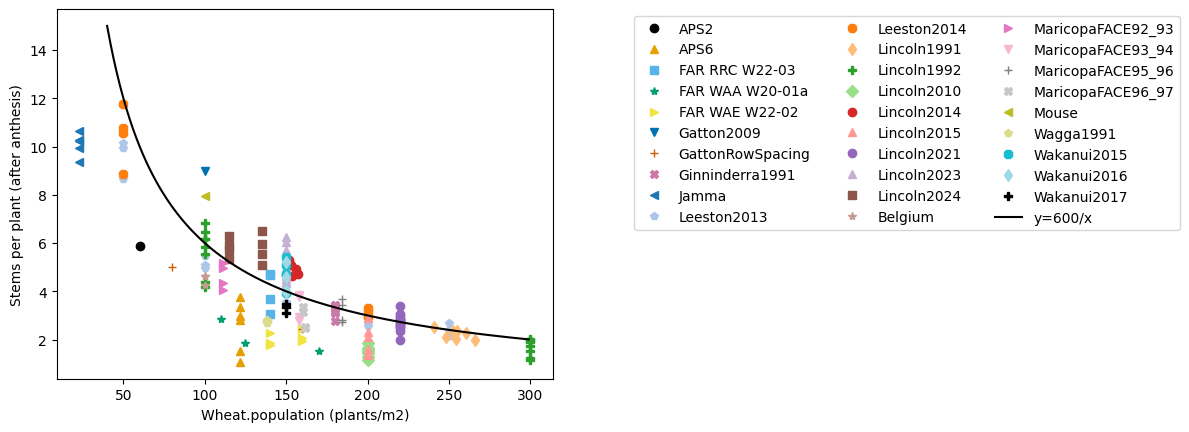

In [192]:
experiments = list(MeanStemData.loc[:,'Experiment'].drop_duplicates())
xvar,yvar = 'Wheat.Population', 'Wheat.Leaf.StemNumberPerPlant'
plotxy(experiments,xvar,yvar,MeanStemData)
xs = range(40,300)
ys = [600/(x+0) for x in xs]
plt.plot(xs,ys,'-',color='k',label='y=600/x')
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)
plt.ylabel('Stems per plant (after anthesis)')
plt.xlabel('Wheat.population (plants/m2)')

(0.0, 1000.0)

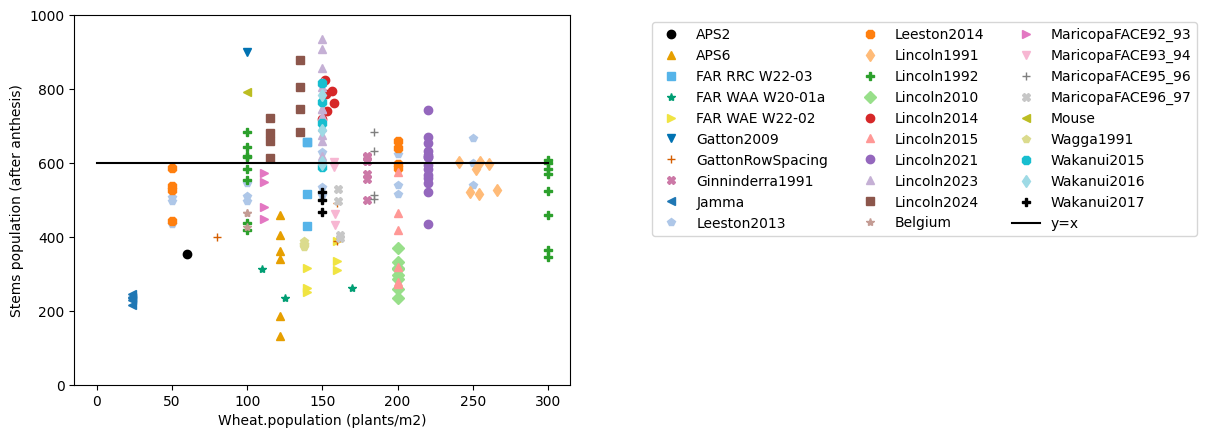

In [193]:
xvar,yvar = 'Wheat.Population', 'Wheat.Leaf.StemPopulation'
plotxy(experiments,xvar,yvar,MeanStemData)

xs = [0,300]
ys = [600,600]
plt.plot(xs,ys,'-',color='k',label='y=x')
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)
plt.ylabel('Stems population (after anthesis)')
plt.xlabel('Wheat.population (plants/m2)')
plt.ylim(0,1000)

Text(0, 0.5, 'Stems population (after anthesis)')

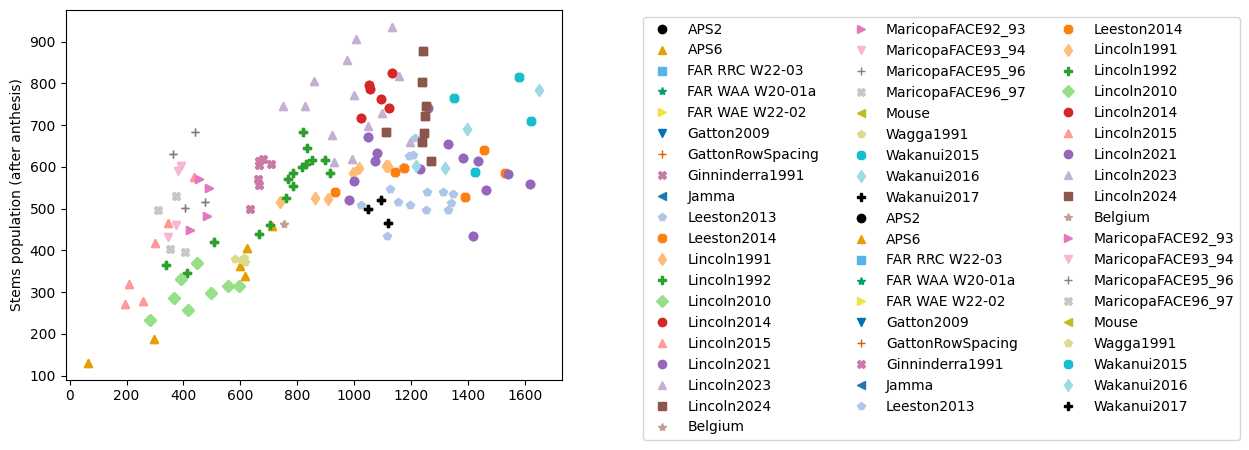

In [194]:
Experiments = list(MeanStemData.loc[:,'Experiment'].drop_duplicates())
cpos=1
mpos=1
for e in Experiments:
    plotData = MeanStemData.loc[MeanStemData.Experiment==e,:]
    plt.plot(plotData.loc[:,'Wheat.Stem.Wt'],plotData.loc[:,'Wheat.Leaf.StemPopulation'],Markers[mpos],color=Colors[cpos],label=e)
    cpos+=1
    mpos+=1
    if mpos>16:
        mpos=1
    if cpos>28:
        cpos=1
        
xvar,yvar = 'Wheat.Stem.Wt', 'Wheat.Leaf.StemPopulation'
plotxy(experiments,xvar,yvar,MeanStemData)

# xs = [0,300]
# ys = [600,600]
# plt.plot(xs,ys,'-',color='k',label='y=x')
plt.legend(bbox_to_anchor=(1.15, 1),numpoints=1,ncols=3)
#plt.ylim(0,1000)

In [131]:
detailedStemData = ['APS2',
 'APS6',
 'GattonRowSpacing',
 'Ginninderra1991',
 'Lincoln1991',
 'Lincoln1992',
 'Lincoln2014',
 'Lincoln2015',
 'Lincoln2023',
 'Lincoln2024',
 'MaricopaFACE92_93',
 'MaricopaFACE93_94',
 'MaricopaFACE95_96',
 'MaricopaFACE96_97',
 'Wagga1991']

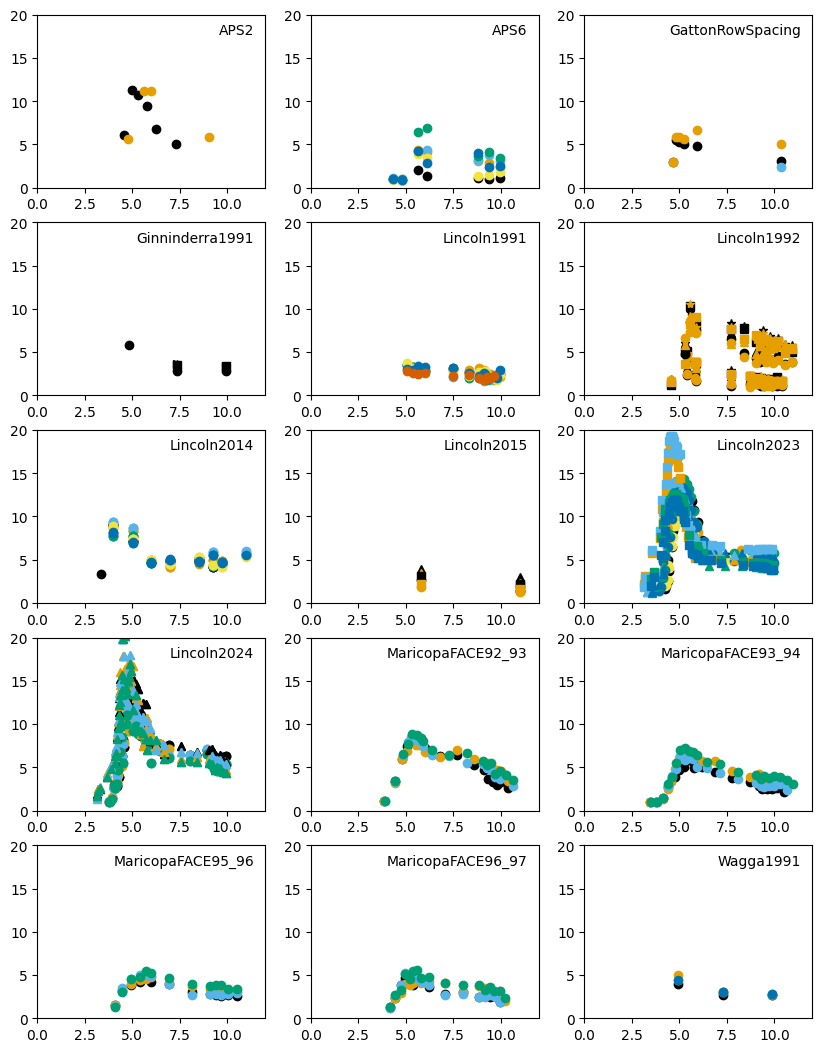

In [162]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.Population','Wheat.Phenology.AccumulatedTT','Wheat.Leaf.StemNumberPerPlant']+['Experiment']
data = Observed.loc[:,vars].dropna(subset= ['Wheat.Leaf.StemPopulation','Wheat.Leaf.StemNumberPerPlant'],how='all')
pos=1
graph = plt.figure(figsize=(10,40))
for e in detailedStemData:
    ax = graph.add_subplot(15,3,pos)
    exData = data.loc[data.Experiment == e,:]
    sims = exData.index.get_level_values(0).drop_duplicates()
    spos = 0
    for s in sims:
        scol = Colors[CondensedFactors.loc[(e,s),'fIndex1']]
        smar = Markers[CondensedFactors.loc[(e,s),'fIndex2']]
        plt.plot(exData.loc[s,'Wheat.Phenology.Stage'],exData.loc[s,'Wheat.Leaf.StemNumberPerPlant'],smar,color=scol,label=e)
    plt.text(0.95,0.95,e,transform = ax.transAxes,horizontalalignment='right', verticalalignment='top')
    pos+=1
    plt.xlim(0,12)
    plt.ylim(0,20)

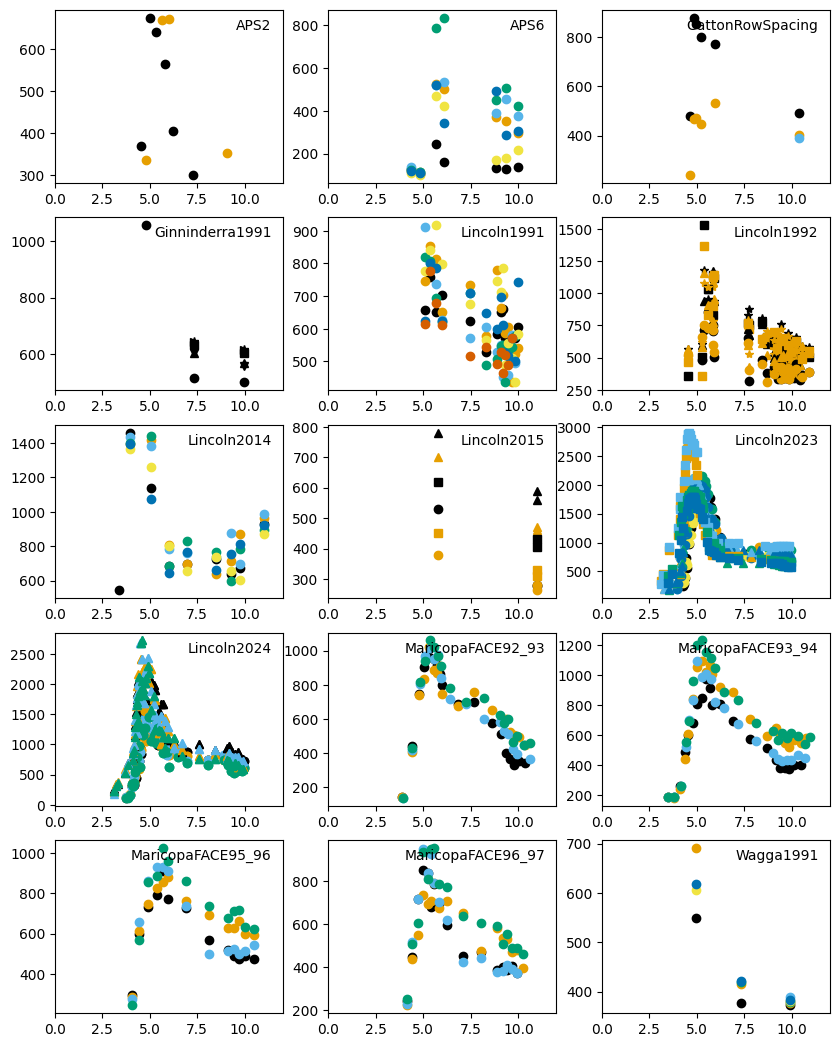

In [160]:
vars = ['Wheat.Leaf.StemPopulation','Wheat.Phenology.Stage','Wheat.Population','Wheat.Phenology.AccumulatedTT','Wheat.Leaf.StemNumberPerPlant']+['Experiment']
data = Observed.loc[:,vars].dropna(subset= ['Wheat.Leaf.StemPopulation','Wheat.Leaf.StemNumberPerPlant'],how='all')
pos=1
graph = plt.figure(figsize=(10,40))
for e in detailedStemData:
    ax = graph.add_subplot(15,3,pos)
    exData = data.loc[data.Experiment == e,:]
    sims = exData.index.get_level_values(0).drop_duplicates()
    spos = 0
    for s in sims:
        scol = Colors[CondensedFactors.loc[(e,s),'fIndex1']]
        smar = Markers[CondensedFactors.loc[(e,s),'fIndex2']]
        plt.plot(exData.loc[s,'Wheat.Phenology.Stage'],exData.loc[s,'Wheat.Leaf.StemPopulation'],smar,color=scol,label=e)
    plt.text(0.95,0.95,e,transform = ax.transAxes,horizontalalignment='right', verticalalignment='top')
    pos+=1
    plt.xlim(0,12)

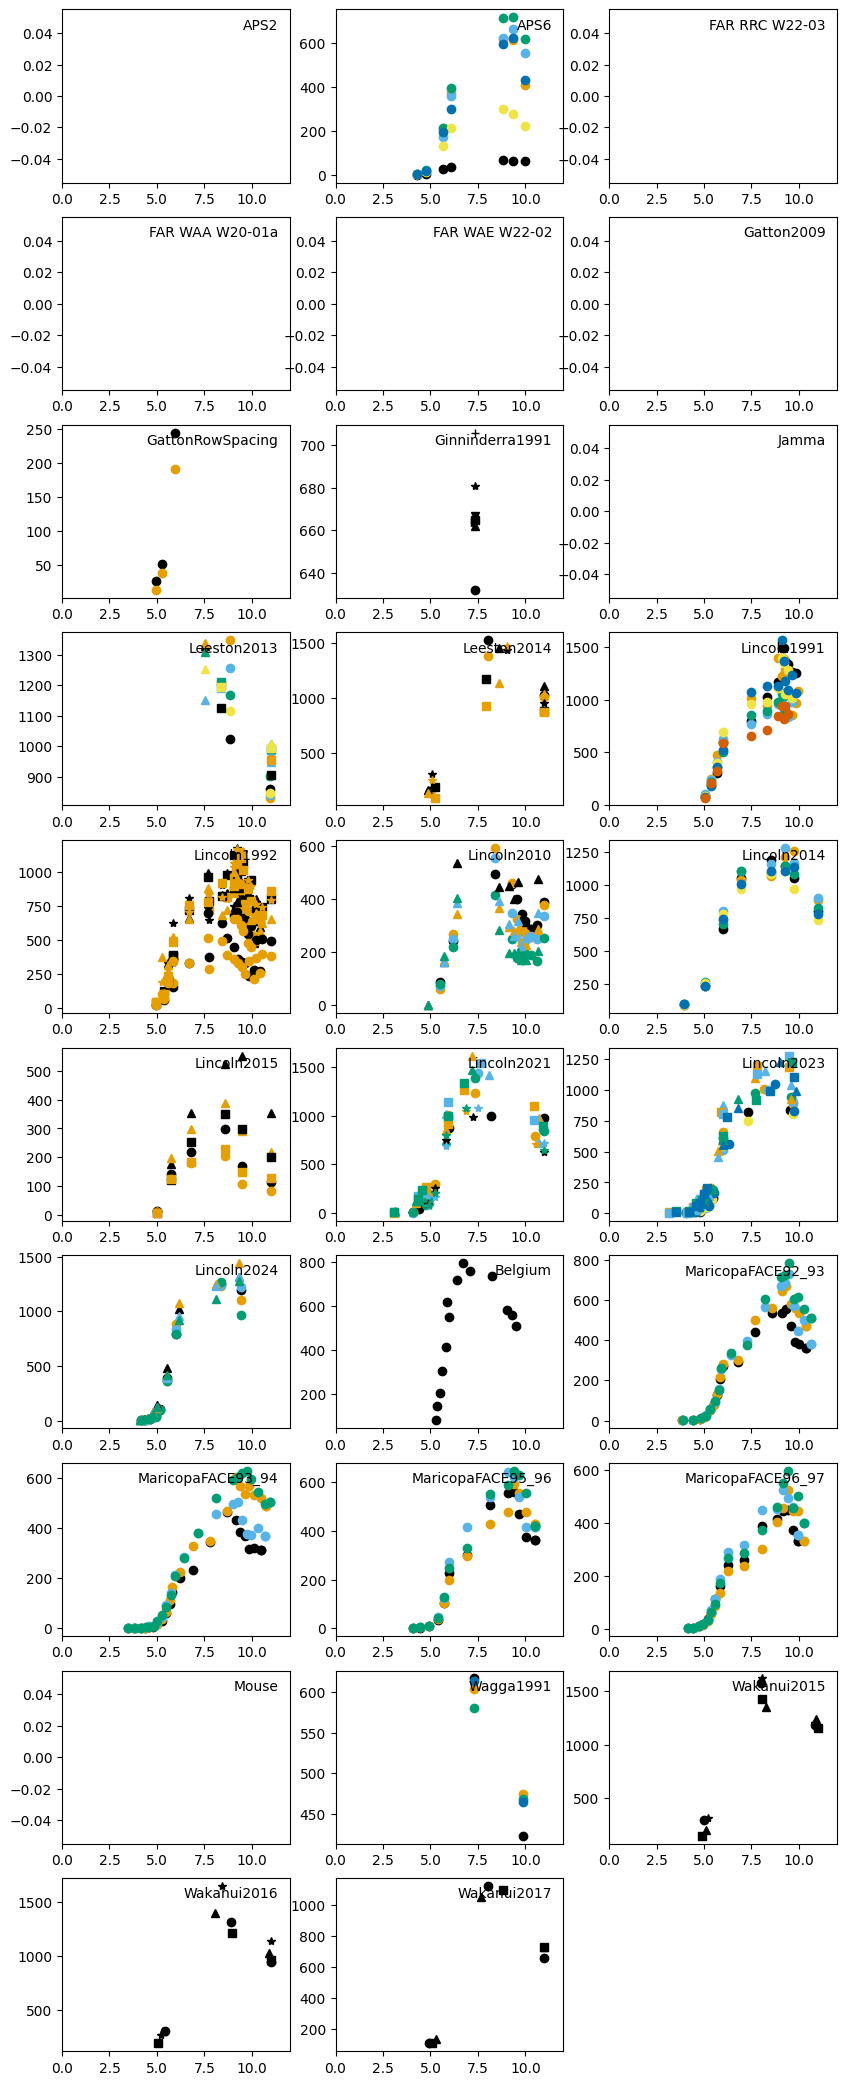

In [165]:
vars = ['Wheat.Stem.Wt','Wheat.Phenology.Stage']+['Experiment']
data = Observed.loc[:,vars].dropna(how='all')
pos=1
graph = plt.figure(figsize=(10,40))
for e in Experiments:
    ax = graph.add_subplot(15,3,pos)
    exData = data.loc[data.Experiment == e,:]
    sims = exData.index.get_level_values(0).drop_duplicates()
    spos = 0
    for s in sims:
        scol = Colors[CondensedFactors.loc[(e,s),'fIndex1']]
        smar = Markers[CondensedFactors.loc[(e,s),'fIndex2']]
        plt.plot(exData.loc[s,'Wheat.Phenology.Stage'],exData.loc[s,'Wheat.Stem.Wt'],smar,color=scol,label=e)
    plt.text(0.95,0.95,e,transform = ax.transAxes,horizontalalignment='right', verticalalignment='top')
    pos+=1
    plt.xlim(0,12)

In [180]:
vars = ['Wheat.Stem.Wt','Wheat.Phenology.Stage']
data = Observed.loc[:,vars].dropna()
MeanStemWtData = data.loc[(data.loc[:,'Wheat.Phenology.Stage']>6.4)&(data.loc[:,'Wheat.Phenology.Stage']<9),:].groupby('SimulationName').mean()
MeanStemWtData.loc[:,'Experiment'] = [getValue(x,'Experiment',HarvestPred) for x in MeanStemWtData.index]
MeanStemData.loc[:,'StemWt'] = MeanStemWtData.reindex(MeanStemData.index).loc[:,'Wheat.Stem.Wt']

In [181]:
MeanStemData

Wheat.Leaf.StemPopulation  \
SimulationName                                            
APS2TOS2                                     353.333333   
APS6NRate0                                   130.481527   
APS6NRate120                                 339.421249   
APS6NRate160                                 406.064860   
APS6NRate360                                 459.143606   
...                                                 ...   
Wakanui2016Sow24-FebCmNormal                 601.807496   
Wakanui2016Sow29-MarCmNormal                 783.452355   
Wakanui2017Sow09-MarCmNormal                 466.421882   
Wakanui2017Sow19-AprCmNormal                 499.366410   
Wakanui2017Sow30-MarCmNormal                 520.489849   

                              Wheat.Phenology.Stage  Wheat.Population  \
SimulationName                                                          
APS2TOS2                                   9.039426             60.00   
APS6NRate0                                 9.389604            121.61   
APS6NRate120                               9.389604            121.61   
APS6NRate160                               9.389604            121.61   
APS6NRate360                               9.389604            121.61   
...                                             ...               ...   
Wakanui2016Sow24-FebCmNormal              11.000000            150.00   
Wakanui2016Sow29-MarCmNormal              11.000000            150.00   
Wakanui2017Sow09-MarCmNormal              11.000000            150.00   
Wakanui2017Sow19-AprCmNormal              11.000000            150.00   
Wakanui2017Sow30-MarCmNormal              11.000000            150.00   

                              Wheat.Phenology.AccumulatedTT  \
SimulationName                                                
APS2TOS2                                        1545.319452   
APS6NRate0                                      1840.171102   
APS6NRate120                                    1840.171102   
APS6NRate160                                    1840.171102   
APS6NRate360                                    1840.171102   
...                                                     ...   
Wakanui2016Sow24-FebCmNormal                    3812.913143   
Wakanui2016Sow29-MarCmNormal                    3288.559596   
Wakanui2017Sow09-MarCmNormal                    3423.267220   
Wakanui2017Sow19-AprCmNormal                    3027.412607   
Wakanui2017Sow30-MarCmNormal                    3270.312607   

                              Wheat.Leaf.StemNumberPerPlant   Experiment  \
SimulationName                                                             
APS2TOS2                                           5.888889         APS2   
APS6NRate0                                         1.072951         APS6   
APS6NRate120                                       2.791064         APS6   
APS6NRate160                                       3.339075         APS6   
APS6NRate360                                       3.775542         APS6   
...                                                     ...          ...   
Wakanui2016Sow24-FebCmNormal                       4.012050  Wakanui2016   
Wakanui2016Sow29-MarCmNormal                       5.223016  Wakanui2016   
Wakanui2017Sow09-MarCmNormal                       3.109479  Wakanui2017   
Wakanui2017Sow19-AprCmNormal                       3.329109  Wakanui2017   
Wakanui2017Sow30-MarCmNormal                       3.469932  Wakanui2017   

                                   StemWt  
SimulationName                             
APS2TOS2                              NaN  
APS6NRate0                      65.500000  
APS6NRate120                   616.200000  
APS6NRate160                   622.300000  
APS6NRate360                   711.900000  
...                                   ...  
Wakanui2016Sow24-FebCmNormal  1216.379391  
Wakanui2016Sow29-MarCmNormal  1648.898828  
Wakanui2017Sow09-MarCmNormal  1119.612385  
Wakanui2017Sow19-Ap